# Отчёт по лабораторной работе №3 "Переобучение и регуляризация"

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# 1. Загрузите данные ex3data1.mat из файла.

In [3]:
from scipy.io import loadmat

def reshape(arr):
    return arr.reshape(arr.shape[0])

mat = loadmat('ex3data1.mat')
X_train, y_train = mat['X'], reshape(mat['y'])
X_val, y_val = mat['Xval'], reshape(mat['yval'])
X_test, y_test = mat['Xtest'], reshape(mat['ytest'])

# 2. Постройте график, где по осям откладываются X и y из обучающей выборки.

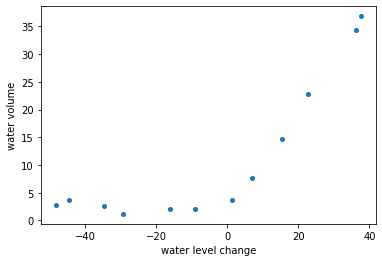

In [4]:
plt.plot(X_train, y_train, 'o', markersize=4)
plt.xlabel('water level change')
plt.ylabel('water volume')
plt.show()

### Реализация линейной регрессии с L2-регуляризацией представлена в классе `LinearRegressionRegularized`

In [5]:
class LinearRegressionRegularized:
    THRESHOLD = 1e-6

    def __init__(self, max_steps=500000, learning_rate=0.01, reg_L=0.5, normalize=False, method=None):
        self.weights = None
        self.normalize = normalize
        self.max_steps = max_steps
        self.learning_rate = learning_rate
        self.reg_L = reg_L
        self.method = method

    def predict(self, X):
        if self.weights is None:
            raise Exception("Model is not trained. Call `fit` method.")

        A = np.insert(X, 0, 1)        
        return self.calculate_hypotesis(A)

    def fit(self, X, y):
        X = X.astype('float64') 
        y = y.astype('float64')
        
        if self.normalize:
            X = self.normalize_features(X)
        
        X = np.column_stack((np.ones(X.shape[0]), X))

        if self.method == 'normal_equation':
            self.weights = self.normal_equation(X, y)
            return

        self.gradient_descent(X, y)

    def normalize_features(self, X):
        N = X.shape[1]
        copy_X = X.copy()
        for i in range(N):
            feature = X[:, i]
            mean = np.mean(feature)
            delta = np.max(feature) - np.min(feature)            
            copy_X[:, i] -= mean
            copy_X[:, i] /= delta
        return copy_X

    def normal_equation(self, X, y):
        return np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
        
    def cost_func(self, X, y, weights=None):
        if weights is None:
            weights = self.weights

        predictions = self.calculate_hypotesis(X, weights)
        sq_error = (predictions - y) ** 2

        weights_R = weights[1:]
        total_cost = sq_error.sum() + self.reg_L * np.dot(weights_R.T, weights_R)
        return total_cost / 2 / X.shape[0]

    def calculate_hypotesis(self, X, weights=None):
        if weights is None:
            weights = self.weights
        
        if len(X.shape) > 1 and X.shape[1] < weights.shape[0]:
            X = np.column_stack((np.ones(X.shape[0]), X))

        return X.dot(weights)

    def gradient_descent(self, X, y):
        self.cost_history = []
        self.weights = np.zeros(X.shape[1])
        cur_loss = self.cost_func(X, y)

        cur_step = 0
        while cur_step < self.max_steps:
            cur_step += 1
            self.gradient_descent_step(X, y)
            new_loss = self.cost_func(X, y)
            self.cost_history.append(new_loss)
            if abs(new_loss - cur_loss) < self.THRESHOLD:
                break

            cur_loss = new_loss

    def gradient_descent_step(self, X, y):
        predictions = self.calculate_hypotesis(X)
        diff = predictions - y
        gradient_first = np.dot(X.T[:1], diff)
        gradient_full = np.dot(X.T[1:], diff) + self.reg_L * self.weights[1:]
        gradient = np.insert(gradient_full, 0, gradient_first)
        gradient /= X.shape[0]
        gradient *= self.learning_rate
        self.weights -= gradient

# 3. Реализуйте функцию стоимости потерь для линейной регрессии с L2-регуляризацией.

функцию стоимости потерь для линейной регрессии с L2-регуляризацией реализована в классе `LogisticRegressionRegularized` в методе `gradient_descent`.

# 4. Реализуйте функцию градиентного спуска для линейной регрессии с L2-регуляризацией.

Функция градиентного спуска для линейной регрессии с L2-регуляризацией реализована в классе `LogisticRegressionRegularized` в методах `gradient_descent` и `gradient_descent_step`.

# 5. Постройте модель линейной регрессии с коэффициентом регуляризации 0 и постройте график полученной функции совместно с графиком из пункта 2. Почему регуляризация в данном случае не сработает?

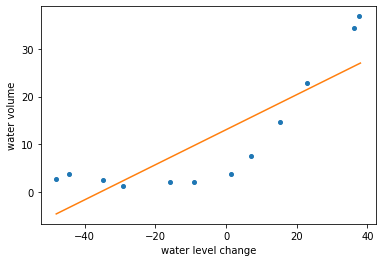

In [6]:
lin = LinearRegressionRegularized(learning_rate=0.001, reg_L=0)
lin.fit(X_train, y_train)

min_x, max_x = int(min(X_train)), int(max(X_train)) + 1
xi = list(range(min_x, max_x + 1))
line = [lin.predict(np.array(i)) for i in xi]
plt.plot(X_train, y_train, 'o', xi, line, markersize=4)
plt.xlabel('water level change')
plt.ylabel('water volume')
plt.show()

В данном случае регуляризация не работает, потому что при нулевом коэфиценте регуляризация функция стоимости потерь и функция градиента приобретает изначальный вид, как при обычной линейной регрессии, т.е. дополнительные слагаемые в этих функциях не играют никакой роли, так как они равны нулю.

График показывает, что простая линейная регрессия не подходит для этой задачи 

# 6. Постройте график процесса обучения (learning curves) для обучающей и валидационной выборки. По оси абсцисс откладывается число элементов из обучающей выборки, а по оси ординат - ошибка (значение функции потерь) для обучающей выборки (первая кривая) и валидационной выборки (вторая кривая). Какой вывод можно сделать по построенному графику?

In [7]:
def learning_curves(lin, X_train, y_train, X_val, y_val, max_axis=100):
    N = len(y_train)
    train_err = np.zeros(N)
    val_err = np.zeros(N)
    
    for i in range(1, N):
        lin.fit(X_train[0:i + 1, :], y_train[0:i + 1])
        train_err[i] = lin.cost_func(X_train[0:i + 1, :], y_train[0:i + 1])
        val_err[i] = lin.cost_func(X_val, y_val)

    plt.plot(range(2, N + 1), train_err[1:], c="r", linewidth=2)
    plt.plot(range(2, N + 1), val_err[1:], c="b", linewidth=2)
    plt.xlabel("number of training examples")
    plt.ylabel("error")
    plt.legend(["training", "validation"], loc="best")
    plt.axis([2, N, 0, max_axis])
    plt.show()

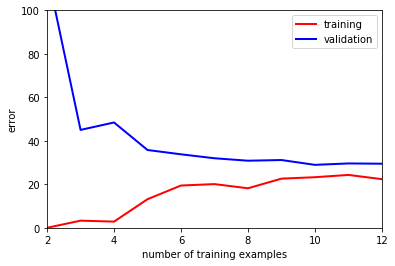

In [8]:
lin = LinearRegressionRegularized(learning_rate=0.001, reg_L=0)
learning_curves(lin, X_train, y_train, X_val, y_val)

Исходя из графика можно сделать вывод, ошибка (значение функии потерь) ни обучающей выборки, ни тренировочной не смогла быть уменьшена в достаточной степени. Это значит, что модель недообучена (high bias problem).

# 7. Реализуйте функцию добавления p - 1 новых признаков в обучающую выборку (X^2, X^3, X^4, …, X^p).

In [10]:
def poly_features(X, p):
    x = X.reshape(X.shape[0])
    X_res = np.array(x)

    for i in range(2, p + 1):
        X_res = np.column_stack((X_res, x ** i))

    return X_res

# 8. Поскольку в данной задаче будет использован полином высокой степени, то необходимо перед обучением произвести нормализацию признаков.

Нормализация реализована в классе `LinearRegressionRegularized` в методе `normalize_features`.

# 9. Обучите модель с коэффициентом регуляризации 0 и p = 8.

In [11]:
DEGREE = 8
lin_reg = LinearRegressionRegularized(learning_rate=1.99999, reg_L=0)
X_train_poly = lin_reg.normalize_features(poly_features(X_train, DEGREE))
lin_reg.fit(X_train_poly, y_train)

# 10. Постройте график модели, совмещенный с обучающей выборкой, а также график процесса обучения. Какой вывод можно сделать в данном случае?

In [12]:
def plot_train_and_fit(model, X, y, degree):
    x = np.linspace(min(X), max(X), 1000)
    X_poly = poly_features(x, degree)
    X_norm = model.normalize_features(X_poly)
    line = [model.predict(i) - 1.5 for i in X_norm]
    plt.plot(X, y, 'o', x, line, markersize=4)
    plt.xlabel('water level change')
    plt.ylabel('water volume')
    plt.show()

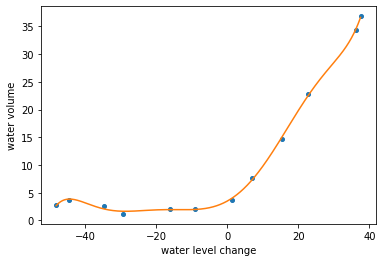

In [13]:
plot_train_and_fit(lin_reg, X_train, y_train, DEGREE)

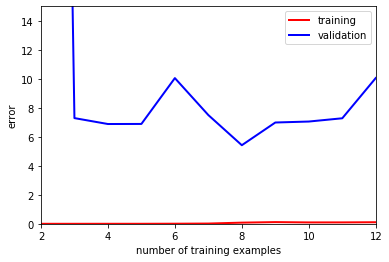

In [14]:
lin_reg_val = LinearRegressionRegularized(learning_rate=1.7, reg_L=0)
X_val_poly = lin_reg_val.normalize_features(poly_features(X_val, DEGREE))
learning_curves(lin_reg_val, X_train_poly, y_train, X_val_poly, y_val, max_axis=15)

Ошибка на обучающей выборке приблизительно равна нулю, а на валидационной выборке не может сойтись. Это говорит о том, что в данном случае мы наблюдаем переобучение модели (high variance problem).

# 11. Постройте графики из пункта 10 для моделей с коэффициентами регуляризации 1 и 100. Какие выводы можно сделать?

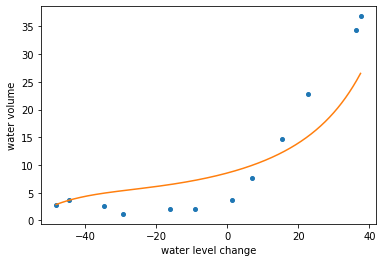

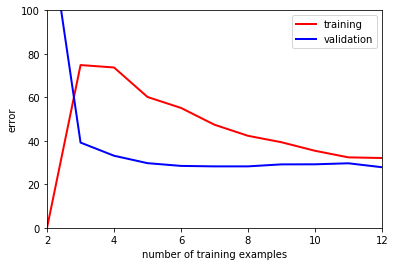

In [15]:
lin_reg_1 = LinearRegressionRegularized(learning_rate=1.5, reg_L=1)
lin_reg_1.fit(X_train_poly, y_train)

plot_train_and_fit(lin_reg_1, X_train, y_train, DEGREE)
learning_curves(lin_reg_1, X_train_poly, y_train, X_val_poly, y_val)

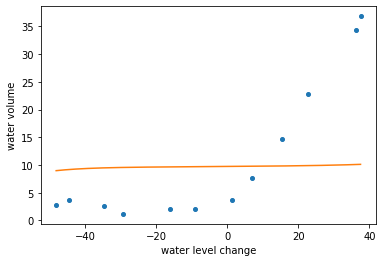

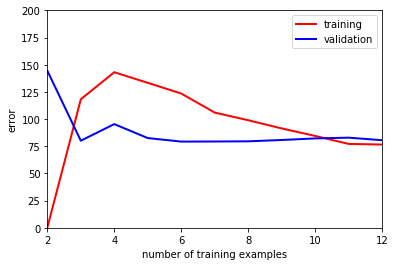

In [16]:
lin_reg_100 = LinearRegressionRegularized(learning_rate=0.001, reg_L=100)
lin_reg_100.fit(X_train_poly, y_train)

plot_train_and_fit(lin_reg_100, X_train, y_train, DEGREE)
learning_curves(lin_reg_100, X_train_poly, y_train, X_val_poly, y_val, max_axis=200)

Таким образом добавляется регуляризация в модель. При коэфициенте равном 1 график модели стал более сглаженным, а значит модель не переобучается. Однако ошибка всё ещё большая. Это значит можно подобрать лучший коэфициент регуляризации.

При коэфициенте равном 100 график модели стремится к горизонтальной прямой. Это связано с тем что на все веса кроме θ0 накладывается большой штраф, поэтому они стремятся к нулю, а функция стоимости стоимости стремится к θ0.

# 12. С помощью валидационной выборки подберите коэффиент регуляризации, который позволяет достичь наименьшей ошибки. Процесс подбора отразите с помощью графика (графиков).

Minimum error is for lambda = 0.03


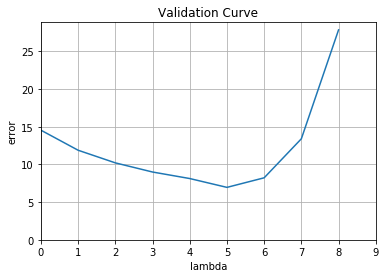

In [17]:
lambda_values = [0, 0.001, 0.003, 0.006, 0.01, 0.03, 0.1, 0.3, 1]
validation_error = []

for lamb in lambda_values:
    lin_reg_lamb = LinearRegressionRegularized(learning_rate=0.5, reg_L=lamb)
    lin_reg_lamb.fit(X_train_poly, y_train)
    cost = lin_reg_lamb.cost_func(X_val_poly, y_val)
    validation_error.append(cost)

OPTIMAL_LAMBDA = lambda_values[np.argmin(np.array(validation_error))]
print(f"Minimum error is for lambda = {OPTIMAL_LAMBDA}")
plt.plot(list(range(len(lambda_values))), validation_error)
plt.axis([0, len(lambda_values), 0, max(validation_error) + 1])
plt.xlabel("lambda")
plt.ylabel("error")
plt.title("Validation Curve")
plt.grid()

# 13. Вычислите ошибку (потерю) на контрольной выборке.

In [18]:
lin_test = LinearRegressionRegularized(learning_rate=1.99999, reg_L=OPTIMAL_LAMBDA)
lin_test.fit(X_train_poly, y_train)

X_test_poly = lin_test.normalize_features(poly_features(X_test, DEGREE))
final_cost = lin_test.cost_func(X_test_poly, y_test)
print(f"Error on test set is {final_cost}")

Error on test set is 11.898903992510654
